In [65]:
import pandas as pd 

df=pd.read_csv("../../data/curated/cleaned_real_estate_data.csv")

df.columns


Index(['postcode', 'weekly_rent', 'days_listed', 'bedrooms', 'bathrooms',
       'carspaces', 'property_type', 'lat', 'lon', 'agency',
       'num_metro_bus_stops', 'num_metro_tram_stops', 'num_metro_train_stops',
       'num_regional_bus_stops', 'num_regional_train_stops', 'num_schools_2km',
       'Median_age_persons', 'Median_mortgage_repay_monthly',
       'Median_tot_prsnl_inc_weekly', 'Median_rent_weekly',
       'Median_tot_fam_inc_weekly', 'Average_num_psns_per_bedroom',
       'Median_tot_hhd_inc_weekly', 'Average_household_size',
       'Owner occupied (%)', 'Mortgage (%)', 'Total rented (%)',
       'Other tenure (%)', 'Unemployment', 'post_gradutae (%)',
       'Graduate_diploma_certificate(%)', 'Bachelor (%)',
       'Advanced_&_Diploma (%)', 'Certificate_level (%)', 'Total_persons',
       'Population-2023', 'incidents_recorded', 'rate_per_100000_population',
       'population_est', 'crime_per_person', 'crime_index', 'crime_rank',
       'available_day', 'available_month

Grouping by subrubs and averaging certain features 

In [66]:
cols_to_drop=['lat', 'lon', 'agency', 'num_metro_bus_stops', 'num_metro_tram_stops', 
              'num_metro_train_stops', 'num_regional_bus_stops',
       'num_regional_train_stops', 'num_schools_2km']

cols_to_avg=['weekly_rent', 'days_listed', 'bedrooms', 'bathrooms', 'carspaces']

df = df.drop(columns=cols_to_drop)
df_suburbs=df.groupby("postcode")[cols_to_avg].mean().reset_index()

other_cols=[c for c in df.columns if not c in cols_to_avg + ["postcode"]]

df_others=df.groupby("postcode")[other_cols].first().reset_index()

df_counts = df.groupby("postcode").size().reset_index(name="total_listings")

df_suburbs = df_suburbs.merge(df_others, on="postcode", how="left") \
                        .merge(df_counts, on="postcode", how="left")

Counting number of schools per suburb and merging 

In [67]:
df_schools=pd.read_csv("../../data/processed/schools/school_locations.csv")

df_counts_schools = df_schools.groupby("Address_Postcode").size().reset_index(name="number_schools")

df_schools = df_counts_schools.rename(columns={"Address_Postcode":"postcode"})

df_suburbs=df_suburbs.merge(df_schools, on="postcode", how="left")

df_suburbs.head()

,postcode,weekly_rent,days_listed,bedrooms,bathrooms,carspaces,property_type,Median_age_persons,Median_mortgage_repay_monthly,Median_tot_prsnl_inc_weekly,...,rate_per_100000_population,population_est,crime_per_person,crime_index,crime_rank,available_day,available_month,available_year,total_listings,number_schools
0,3000,692.881944,24.725694,1.694444,1.291667,1.010417,Apartment / Unit / Flat,30.0,1770.0,884.0,...,12685.718229,131663.822225,0.126857,2.250501,22.5,1,7,2025,288,3.0
1,3002,812.241379,194.034483,1.689655,1.241379,1.172414,Apartment / Unit / Flat,42.0,2383.0,1532.0,...,15279.661613,148350.788700,0.152797,2.710678,8.0,7,5,2013,29,NaN
2,3003,737.026667,82.893333,1.826667,1.413333,1.106667,Apartment / Unit / Flat,31.0,2135.0,1047.0,...,14045.560514,144950.229275,0.140456,2.491743,16.5,28,7,2025,75,1.0
3,3006,787.881356,42.006780,1.742373,1.420339,1.050847,Apartment / Unit / Flat,31.0,1820.0,1152.0,...,14275.615246,154650.951900,0.142756,2.532556,15.0,6,10,2025,295,2.0
4,3008,749.500000,71.645833,1.576389,1.368056,1.118056,Apartment / Unit / Flat,32.0,2000.0,1182.0,...,14275.615246,154650.951900,0.142756,2.532556,15.0,26,9,2025,144,1.0


In [9]:
import requests
import zipfile
import pandas as pd
import geopandas as gpd
from pathlib import Path
import os
import time


directories = ['../../data/landing/boundaries']
for directory in directories:
    Path(directory).mkdir(parents=True, exist_ok=True)

# Download SA2 boundaries
url = "https://www.abs.gov.au/statistics/standards/australian-statistical-geography-standard-asgs-edition-3/jul2021-jun2026/access-and-downloads/digital-boundary-files/POA_2021_AUST_GDA2020_SHP.zip"


print("Downloading postal areas boundaries...")
response = requests.get(url, timeout=120)
response.raise_for_status()

zip_path = Path('../../data/landing/boundaries/POA_2021_AUST_GDA2020.zip')
with open(zip_path, 'wb') as f:
    f.write(response.content)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('../../data/landing/boundaries/')

print("POA boundaries downloaded")

POA boundaries downloaded


Spatial join for transport stops and suburb boundaries to get number of stops per suburbs 

In [68]:
import geopandas as gdp
from shapely.geometry import Point
import pandas as pd

transport=pd.read_csv("../../data/processed/transport/transport_stops.csv")

# Create geometry column 

gdf_transport = gdp.GeoDataFrame(transport, geometry=gdp.points_from_xy(transport["Longitude"], transport["Latitude"]),
crs="EPSG:4326"
)
# Load postocde boundaries
shape = gdp.read_file("../../data/landing/boundaries/POA_2021_AUST_GDA2020.shp")
shape = shape.to_crs(gdf_transport.crs)

# Spatial join 
gdf_joined = gdp.sjoin(gdf_transport, shape, how = "left", predicate = "within")


# Count stops per postcode *and StopType*
stops_per_postcode = (
    gdf_joined.groupby(["POA_NAME21", "StopType"])
    .size()
    .reset_index(name="count")
)

# Pivot so each StopType becomes a column
stops_wide = stops_per_postcode.pivot_table(
    index="POA_NAME21",
    columns="StopType",
    values="count",
    fill_value=0
).reset_index()

stops_wide["POA_NAME21"] = stops_wide["POA_NAME21"].astype(int)

stops = stops_wide.rename(columns={"POA_NAME21":"postcode"})
stops.head()


StopType,postcode,Metro Bus,Metro Train,Metro Tram,Regional Bus,Regional Train
0,2640,0.0,0.0,0.0,153.0,1.0
1,2641,0.0,0.0,0.0,39.0,0.0
2,2642,0.0,0.0,0.0,1.0,0.0
3,2643,0.0,0.0,0.0,2.0,0.0
4,2646,0.0,0.0,0.0,1.0,0.0


In [69]:
df_suburbs=df_suburbs.merge(stops, on="postcode", how="left")
df_suburbs.columns

Index(['postcode', 'weekly_rent', 'days_listed', 'bedrooms', 'bathrooms',
       'carspaces', 'property_type', 'Median_age_persons',
       'Median_mortgage_repay_monthly', 'Median_tot_prsnl_inc_weekly',
       'Median_rent_weekly', 'Median_tot_fam_inc_weekly',
       'Average_num_psns_per_bedroom', 'Median_tot_hhd_inc_weekly',
       'Average_household_size', 'Owner occupied (%)', 'Mortgage (%)',
       'Total rented (%)', 'Other tenure (%)', 'Unemployment',
       'post_gradutae (%)', 'Graduate_diploma_certificate(%)', 'Bachelor (%)',
       'Advanced_&_Diploma (%)', 'Certificate_level (%)', 'Total_persons',
       'Population-2023', 'incidents_recorded', 'rate_per_100000_population',
       'population_est', 'crime_per_person', 'crime_index', 'crime_rank',
       'available_day', 'available_month', 'available_year', 'total_listings',
       'number_schools', 'Metro Bus', 'Metro Train', 'Metro Tram',
       'Regional Bus', 'Regional Train'],
      dtype='object')

In [70]:
dropped = ['property_type', 'available_day', 'available_month', 'available_year', 'Average_num_psns_per_bedroom', 'Median_tot_hhd_inc_weekly',
       'Average_household_size', 'Owner occupied (%)', 'Mortgage (%)',
       'Total rented (%)']

suburbs = df_suburbs.drop(columns=dropped)



In [71]:
suburbs["listings_per_person"]=suburbs['total_listings']/suburbs['Population-2023']

suburbs.head()

,postcode,weekly_rent,days_listed,bedrooms,bathrooms,carspaces,Median_age_persons,Median_mortgage_repay_monthly,Median_tot_prsnl_inc_weekly,Median_rent_weekly,...,crime_index,crime_rank,total_listings,number_schools,Metro Bus,Metro Train,Metro Tram,Regional Bus,Regional Train,listings_per_person
0,3000,692.881944,24.725694,1.694444,1.291667,1.010417,30.0,1770.0,884.0,375.0,...,2.250501,22.5,288,3.0,30.0,2.0,40.0,0.0,1.0,0.015985
1,3002,812.241379,194.034483,1.689655,1.241379,1.172414,42.0,2383.0,1532.0,480.0,...,2.710678,8.0,29,NaN,8.0,2.0,15.0,0.0,0.0,0.005686
2,3003,737.026667,82.893333,1.826667,1.413333,1.106667,31.0,2135.0,1047.0,390.0,...,2.491743,16.5,75,1.0,25.0,3.0,4.0,0.0,1.0,0.008597
3,3006,787.881356,42.006780,1.742373,1.420339,1.050847,31.0,1820.0,1152.0,408.0,...,2.532556,15.0,295,2.0,8.0,0.0,16.0,0.0,0.0,0.023577
4,3008,749.500000,71.645833,1.576389,1.368056,1.118056,32.0,2000.0,1182.0,411.0,...,2.532556,15.0,144,1.0,12.0,1.0,19.0,0.0,1.0,0.057762


In [76]:
names = pd.read_csv("../../data/processed/real_estate/vic_rentals_all_enriched.csv")

drop = [name for name in names.columns if name not in ['suburb', 'postcode']]

names_d = names.drop(columns=drop)

names_map = (names_d.groupby("postcode")["suburb"]
             .agg(lambda s: s.value_counts().idxmax())
             .reset_index())

In [77]:
suburbs_n = suburbs.merge(names_map, on='postcode', how='left')

suburbs_n.head()

,postcode,weekly_rent,days_listed,bedrooms,bathrooms,carspaces,Median_age_persons,Median_mortgage_repay_monthly,Median_tot_prsnl_inc_weekly,Median_rent_weekly,...,crime_rank,total_listings,number_schools,Metro Bus,Metro Train,Metro Tram,Regional Bus,Regional Train,listings_per_person,suburb
0,3000,692.881944,24.725694,1.694444,1.291667,1.010417,30.0,1770.0,884.0,375.0,...,22.5,288,3.0,30.0,2.0,40.0,0.0,1.0,0.015985,MELBOURNE
1,3002,812.241379,194.034483,1.689655,1.241379,1.172414,42.0,2383.0,1532.0,480.0,...,8.0,29,NaN,8.0,2.0,15.0,0.0,0.0,0.005686,EAST MELBOURNE
2,3003,737.026667,82.893333,1.826667,1.413333,1.106667,31.0,2135.0,1047.0,390.0,...,16.5,75,1.0,25.0,3.0,4.0,0.0,1.0,0.008597,WEST MELBOURNE
3,3006,787.881356,42.006780,1.742373,1.420339,1.050847,31.0,1820.0,1152.0,408.0,...,15.0,295,2.0,8.0,0.0,16.0,0.0,0.0,0.023577,SOUTHBANK
4,3008,749.500000,71.645833,1.576389,1.368056,1.118056,32.0,2000.0,1182.0,411.0,...,15.0,144,1.0,12.0,1.0,19.0,0.0,1.0,0.057762,DOCKLANDS


Top 10 suburbs by total listings and listings per person (not great as many subrubs have very few listings)

In [81]:

top_suburbs = suburbs_n.sort_values("total_listings", ascending=False).head(10)
print(top_suburbs[["suburb", "total_listings"]])

top_per_person = suburbs_n.sort_values("listings_per_person", ascending=False)
print(top_per_person[["suburb", "listings_per_person"]])

          suburb  total_listings
19       TARNEIT             595
20    POINT COOK             399
49   CRAIGIEBURN             382
3      SOUTHBANK             295
0      MELBOURNE             288
109  SOUTH YARRA             197
5      FOOTSCRAY             173
145     ST KILDA             166
132      CLAYTON             158
4      DOCKLANDS             144
             suburb  listings_per_person
392          FOSTER             0.200000
295        JAMIESON             0.130435
4         DOCKLANDS             0.057762
20       POINT COOK             0.039908
162  PORT MELBOURNE             0.031689
..              ...                  ...
191       BUSHFIELD             0.000044
346           NILMA             0.000041
170       GNARWARRE             0.000040
277       BROADFORD             0.000038
403            BASS             0.000035

[407 rows x 2 columns]


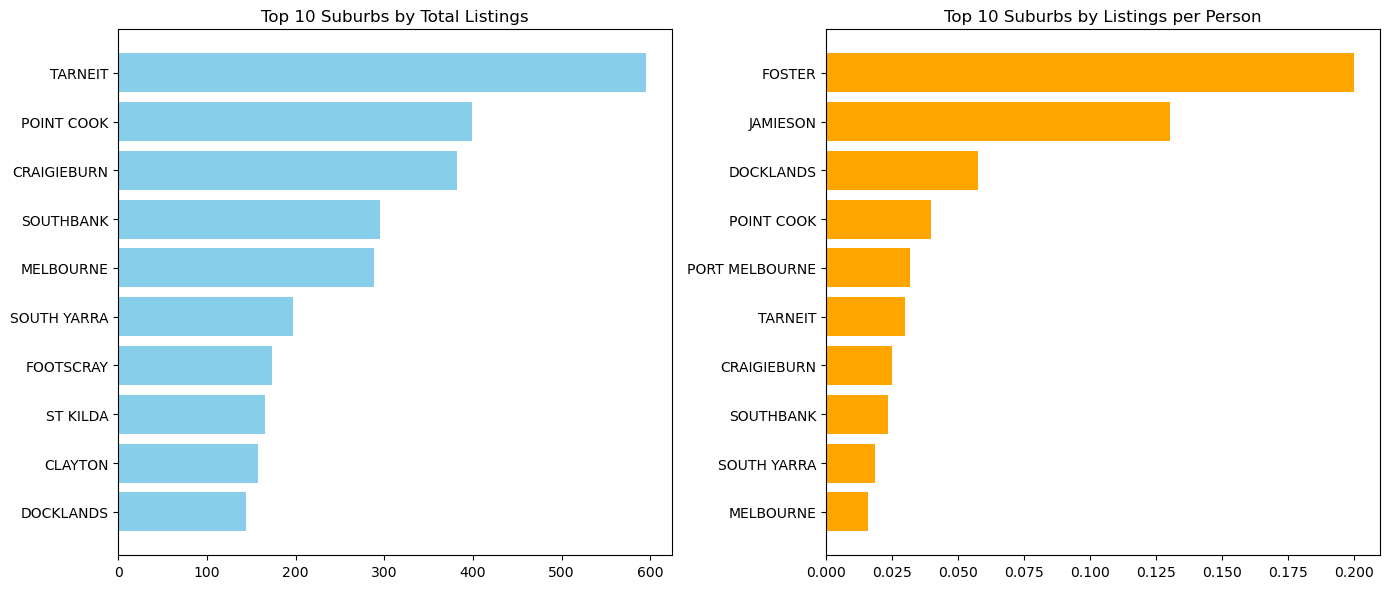

In [82]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14,6))

# Top 10 by total listings
top_suburbs = suburbs_n.sort_values("total_listings", ascending=False).head(10)
axes[0].barh(top_suburbs["suburb"], top_suburbs["total_listings"], color="skyblue")
axes[0].set_title("Top 10 Suburbs by Total Listings")
axes[0].invert_yaxis()

# Top 10 by listings per person
top_per_person = suburbs_n.sort_values("listings_per_person", ascending=False).head(10)
axes[1].barh(top_per_person["suburb"], top_per_person["listings_per_person"], color="orange")
axes[1].set_title("Top 10 Suburbs by Listings per Person")
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()


Random Forest for feature importance, both for total listings and listings per person

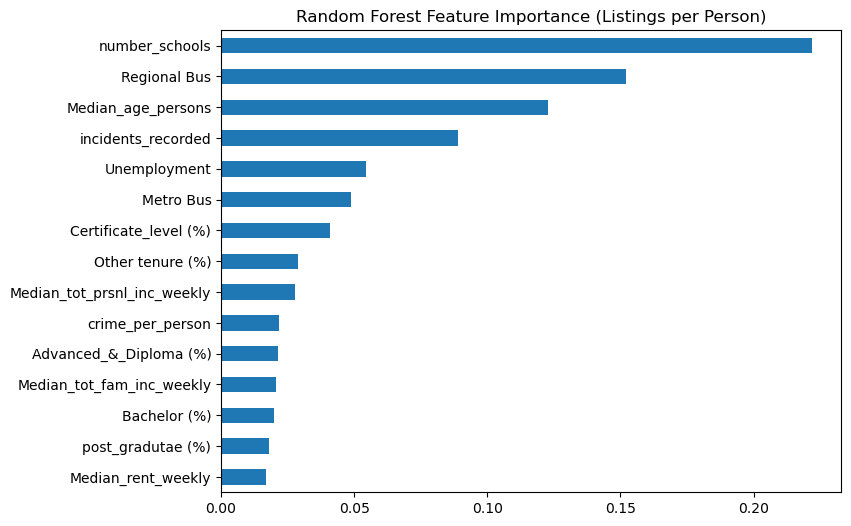

In [94]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

# 1. Select features and target
target = "listings_per_person"
exclude_cols = ["suburb", "postcode", "total_listings", "Population-2023", "bedrooms",
                "bathrooms", "days_listed", "weekly_rent", "carspaces",
                "Total_persons", "population_est", target]

X = suburbs_n.drop(columns=exclude_cols, errors="ignore")
y = suburbs_n[target]

# Keep only numeric columns
X = X.select_dtypes(include="number").fillna(0)

# 2. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Fit Random Forest
rf = RandomForestRegressor(n_estimators=500, random_state=42)
rf.fit(X_train, y_train)

# 4. Feature importances
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

# 5. Plot
plt.figure(figsize=(8,6))
importances.head(15).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Random Forest Feature Importance (Listings per Person)")
plt.show()


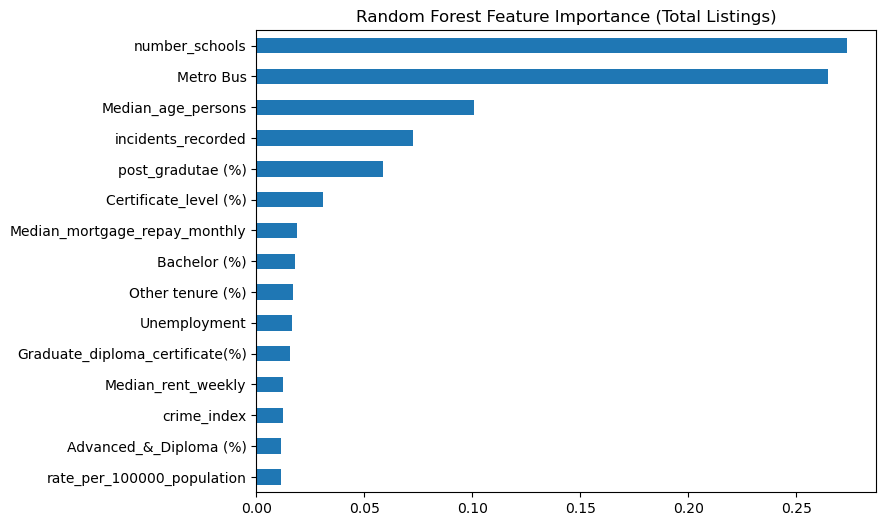

In [96]:
target = "total_listings"
exclude_cols = ["suburb", "postcode", "listings_per_person","Population-2023", "bedrooms",
                "bathrooms", "days_listed", "weekly_rent", "carspaces",
                "Total_persons", "population_est", target]

X = suburbs_n.drop(columns=exclude_cols, errors="ignore")
y = suburbs_n[target]

# Keep only numeric columns
X = X.select_dtypes(include="number").fillna(0)

# 2. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 3. Fit Random Forest
rf = RandomForestRegressor(n_estimators=500, random_state=42)
rf.fit(X_train, y_train)

# 4. Feature importances
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

# 5. Plot
plt.figure(figsize=(8,6))
importances.head(15).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Random Forest Feature Importance (Total Listings)")
plt.show()

              precision    recall  f1-score   support

           0       0.90      0.97      0.93        65
           1       0.83      0.59      0.69        17

    accuracy                           0.89        82
   macro avg       0.87      0.78      0.81        82
weighted avg       0.89      0.89      0.88        82



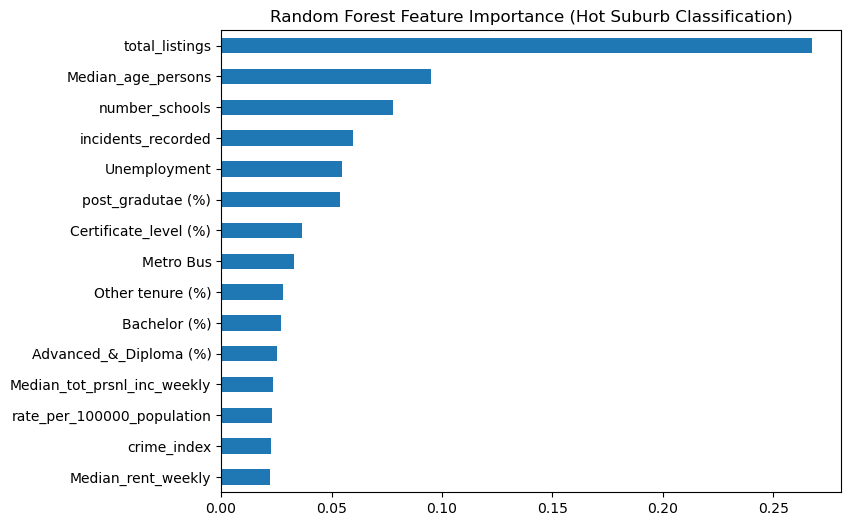

In [101]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pandas as pd
import matplotlib.pyplot as plt

# 1. Create binary target: top 20% = hot suburb
threshold = suburbs_n["listings_per_person"].quantile(0.8)
suburbs_n["hot_suburb"] = (suburbs_n["listings_per_person"] >= threshold).astype(int)

# 2. Features
exclude_cols = ["suburb", "postcode", "listings_per_person","Population-2023", "bedrooms",
                "bathrooms", "days_listed", "weekly_rent", "carspaces",
                "Total_persons", "population_est", "hot_suburb"]
X = suburbs_n.drop(columns=exclude_cols, errors="ignore").select_dtypes(include="number").fillna(0)
y = suburbs_n["hot_suburb"]

# 3. Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 4. Train classifier
clf = RandomForestClassifier(n_estimators=500, random_state=42, class_weight="balanced")
clf.fit(X_train, y_train)

# 5. Evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

# 6. Feature importances
importances = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(8,6))
importances.head(15).plot(kind="barh")
plt.gca().invert_yaxis()
plt.title("Random Forest Feature Importance (Hot Suburb Classification)")
plt.show()
